In [27]:
import pandas as pd
import matplotlib as plt
import numpy as np

In [4]:
# sourced from stooq.com
spx_df = pd.read_csv('SPX.csv', parse_dates=['Date'])

In [5]:
# sourced from Yahoo Finance
upro_df = pd.read_csv('UPRO.csv', parse_dates=['Date'])

In [6]:
spx_df.set_index('Date', inplace=True)

In [7]:
upro_df.set_index('Date', inplace=True)

In [8]:
df = pd.concat([spx_df.Close, upro_df.Close], axis=1)

In [9]:
df.columns = ['SPX_Close', 'UPRO_Close']

In [10]:
df.isnull().sum()

SPX_Close     0
UPRO_Close    0
dtype: int64

In [11]:
df.shape

(3394, 2)

In [12]:
df.head()

,SPX_Close,UPRO_Close
Date,,
2009-06-26,918.90,1.199306
2009-06-29,927.23,1.233333
2009-06-30,919.32,1.203889
2009-07-01,923.33,1.216806
2009-07-02,896.42,1.116389


In [13]:
norm_factor = df.SPX_Close[0] / df.UPRO_Close[0]

In [14]:
norm_factor

766.1931150181855

In [15]:
df['SPX_normalized'] = df.SPX_Close / norm_factor

<AxesSubplot:xlabel='Date'>

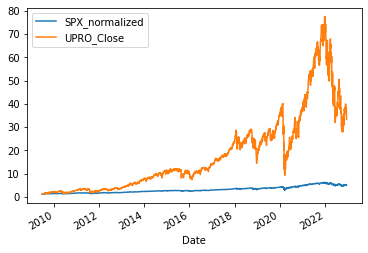

In [16]:
df[['SPX_normalized', 'UPRO_Close']].plot()

In [34]:
# numbers as of EOD 12-20-22 (pretend these were the numbers as of EOD 06-26-09):
init_nlv = 89390 # initial net liquidation value
init_gpv = 117252 # initial gross position value (total value of shares)
# for simplicity, just calculate init_cash as init_nlv - init_gpv (not exactly correct, but close)
init_cash = init_nlv - init_gpv # negative by convention
# init_cash = -27768
# init_mtd_int = -94 # interest will only be charged at end of month
init_ex_liq = 1452 # initial excess liquidity
# assume that this is the max gpv/nlv proportion before liquidation occurs
max_margin_factor = (init_gpv + init_ex_liq) / init_nlv
int_rate_100K = 0.0583 # interest rate up to $100K
int_rate_1M = 0.0533 # interest rate up to $1M

In [36]:
max_margin_factor

1.3279337733527241

In [29]:
# fill-in missing dates
df = df.resample('D').sum().replace(0, np.nan)

In [30]:
df

,SPX_Close,UPRO_Close,SPX_normalized
Date,,,
2009-06-26,918.90,1.199306,1.199306
2009-06-27,NaN,NaN,NaN
2009-06-28,NaN,NaN,NaN
2009-06-29,927.23,1.233333,1.210178
2009-06-30,919.32,1.203889,1.199854
...,...,...,...
2022-12-12,3990.56,37.299999,5.208295
2022-12-13,4019.65,38.110001,5.246262
2022-12-14,3995.32,37.410000,5.214508


In [81]:
(4/3) * ex_liq_decision_threshold

3733.333333333333

In [109]:
gpv_series = pd.Series([None] * df.shape[0], index=df.index)
nlv_series = pd.Series([None] * df.shape[0], index=df.index)
cash_series = pd.Series([None] * df.shape[0], index=df.index)
# iterate through each day from the beginning
upro_yesterday_close = df.iloc[0].UPRO_Close
gpv_series[df.index[0]] = init_gpv
nlv_series[df.index[0]] = init_gpv + init_cash
cash_series[df.index[0]] = init_cash
gpv = init_gpv
cash = init_cash
# ex_liq = init_ex_liq
margin_call_cushion = 1500 # extra amount (in dollars) that is sold in a margin call
ex_liq_decision_threshold = 2800 # buy once excess liquidity reaches this value
ex_liq_left_over = 1000 # amount of excess liquidity to leave over after buying
for i, date in enumerate(df.index[1:]):
    upro_today_close = df.loc[date, 'UPRO_Close']
    # If stock market wasn't open on this day, only charge interest.
    if pd.isnull(upro_today_close):
        # charge daily interest
        # (just assume all interest is charged at the first 100K rate)
        days_in_year = pd.Timestamp(date.year, 12, 31).dayofyear
        daily_int_rate = int_rate_100K / days_in_year
        daily_interest = -daily_int_rate * cash
        cash -= daily_interest
    else:
        pct_change = upro_today_close / upro_yesterday_close
        upro_yesterday_close = upro_today_close # reset yesterday close value
        gpv = pct_change * gpv # update gpv for change in share price
        # nlv = gpv - cash # update nlv for change in share price
        # equivalent to `gpv / nlv > max_margin_factor`
        if gpv < -max_margin_factor * cash / (max_margin_factor - 1):
            # sell just enough shares to get margin_factor < max_margin_factor,
            # then add in $1000 worth of shares
            min_sale_value = (gpv + max_margin_factor * cash / (max_margin_factor - 1)) / (1 - max_margin_factor / (max_margin_factor - 1))
            # Don't worry about commissions or rounding to the nearest share for now,
            # since these effects are negligible.
            sale_value = min_sale_value + margin_call_cushion
            gpv -= sale_value
            cash += sale_value
        # decide whether to invest more
        max_purchase_value = max_margin_factor * cash + gpv * (max_margin_factor - 1)
        # print(max_purchase_value)
        if max_purchase_value > (4/3) * ex_liq_decision_threshold:
            purchase_value = max_purchase_value - (4/3) * ex_liq_left_over
            gpv += purchase_value
            cash -= purchase_value
            # __import__('pdb').set_trace()
        # charge daily interest
        # (just assume all interest is charged at the first 100K rate)
        days_in_year = pd.Timestamp(date.year, 12, 31).dayofyear
        daily_int_rate = int_rate_100K / days_in_year
        daily_interest = -daily_int_rate * cash
        cash -= daily_interest
        # print(daily_interest)
        # __import__('pdb').set_trace()
    gpv_series[date] = gpv
    nlv_series[date] = gpv + cash # note that cash is negative here
    cash_series[date] = cash

In [110]:
gpv

3132206.7158470857

In [111]:
nlv_series

Date
2009-06-26             89390
2009-06-27      89385.549713
2009-06-28      89381.098716
2009-06-29       92703.34912
2009-06-30      89820.258649
                   ...      
2022-12-12    2741140.195288
2022-12-13    2820014.786307
2022-12-14    2751107.797433
2022-12-15     2479593.47313
2022-12-16    2359713.228709
Freq: D, Length: 4922, dtype: object

In [116]:
gpv_series

Date
2009-06-26            117252
2009-06-27            117252
2009-06-28            117252
2009-06-29     120578.702113
2009-06-30      117700.06406
                   ...      
2022-12-12    3638909.701001
2022-12-13    3743655.420809
2022-12-14    3651980.007858
2022-12-15    3291408.080069
2022-12-16    3132206.715847
Freq: D, Length: 4922, dtype: object

In [115]:
cash_series

Date
2009-06-26           -27862
2009-06-27    -27866.450287
2009-06-28    -27870.901284
2009-06-29    -27875.352992
2009-06-30    -27879.805412
                  ...      
2022-12-12   -897769.505713
2022-12-13   -923640.634502
2022-12-14   -900872.210425
2022-12-15   -811814.606939
2022-12-16   -772493.487138
Freq: D, Length: 4922, dtype: object

<AxesSubplot:xlabel='Date'>

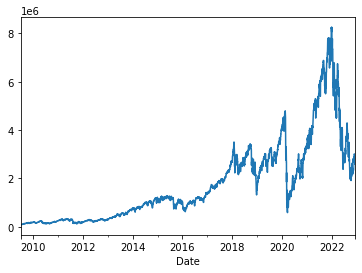

In [112]:
nlv_series.plot()

<AxesSubplot:xlabel='Date'>

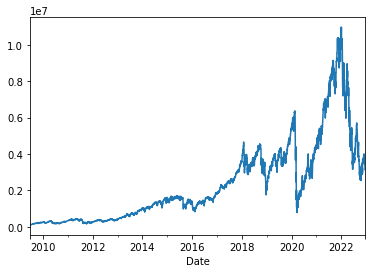

In [113]:
gpv_series.plot()

<AxesSubplot:xlabel='Date'>

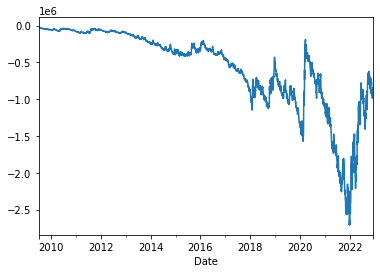

In [114]:
cash_series.plot()

In [45]:
date

Timestamp('2022-12-16 00:00:00', freq='D')

In [47]:
pct_change

27.824424292048903

In [46]:
gpv

inf

In [32]:
upro_today_close

33.369999

In [33]:
33.37 / 1.20

27.808333333333334